### Imports

In [1]:
import numpy  as np
import pandas as pd
import random

from random import randrange, uniform

import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers    import RMSprop
from sklearn.model_selection        import train_test_split

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [3]:
phot_list, compt_list = [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmdepth_all_images.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
compt_images = np.array(compt_list)
phot_images  = np.array(phot_list)

#### Create the noisy events

In [4]:
noise_images = 20 *np.random.rand(5000, 400) #20 has been chosen randomly

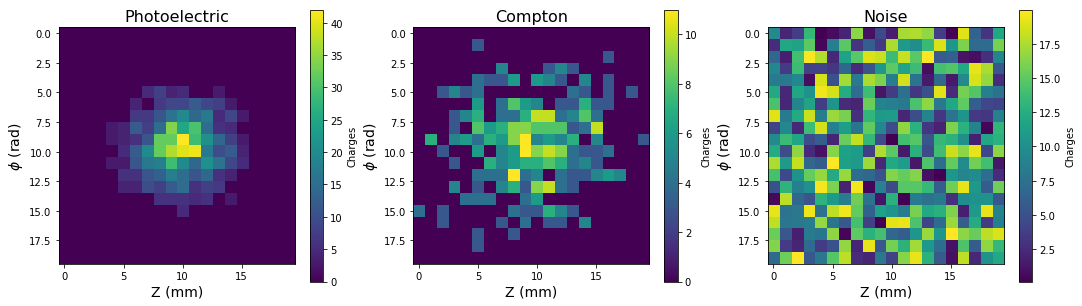

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[9].reshape(20,20))
fig3 = ax3.imshow(noise_images[0].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
ax3.set_xlabel('Z (mm)',       size=14)
ax3.set_ylabel('$\phi$ (rad)', size=14)
ax3.set_title('Noise',         size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
fig.colorbar(fig3, ax=ax3, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1
- noise:         2

In [6]:
compt_labels =   np.zeros(len(compt_images))
phot_labels  =   np.ones (len( phot_images))
noise_labels = 2*np.ones (len(noise_images))

## Inputs for the CNN: data without normalization

In [7]:
y = np.concatenate((compt_labels, phot_labels))
x = np.concatenate((phot_images, compt_images))
#y = np.concatenate((compt_labels, phot_labels, noise_labels))
#x = np.concatenate((phot_images, compt_images, noise_images))
print(y.shape)
print(x.shape)
print(y)

(42176,)
(42176, 400)
[0. 0. 0. ... 1. 1. 1.]


We want to mix the images so that they are not in order (but labels in the same way too):
(we could use the function split_test_train, it also mixes but it splits in two, and we have test, train, val

In [8]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32')

Split data in training, validation and testing:

In [9]:
#######
train_split = 35000
#######
test_split  = 2000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [10]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(2000, 400) (2000,)
(35000, 400) (35000,)
(5176, 400) (5176,)


### Prepare the data
The y variables (outputs) are in classes from 0 to 2. **One-hot** changes this simple number (class) to a matrix which contains 0 for all the entries except for 1 or 2 in case we have phot or noise. This is simply implemented using keras utilities

In [11]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(35000, 2)
(5176, 2)
(2000, 2)


35000 train samples
5176 validation samples


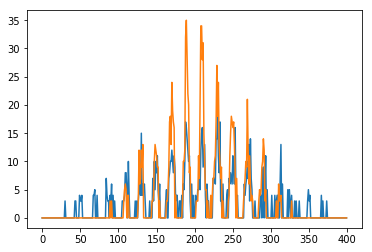

In [12]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
#plt.plot(x_train[1])
plt.plot(x_test[2])
plt.show()

Reshape data for CNN:

In [13]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
print(x_train.shape)
print(x_train_cnn.shape)

(35000, 400)
(35000, 20, 20, 1)


Layer activation relu:
Applies the rectified linear unit activation function.
With default values, this returns the standard ReLU activation: max(x, 0), 
the element-wise maximum of 0 and the input tensor.

In [57]:
# Sequential means you can build a DNN layer by layer
cnnmodel = Sequential()
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((2, 2))) #Max pooling operation for 2D spatial data.
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(2, activation='softmax'))
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10370     
Total params: 11,010
Trainable params: 11,010
Non-trainable params: 0
_________________________________________________________________


In [58]:
batch_size = 32
epochs     = 10

Train the CNN:

In [59]:
# Training our CNN
history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot))

Train on 35000 samples, validate on 5176 samples
Epoch 1/10
35000/35000 [==============================] - 13s 376us/sample - loss: 0.6079 - accuracy: 0.7068 - val_loss: 0.5854 - val_accuracy: 0.7311
Epoch 2/10
35000/35000 [==============================] - 12s 346us/sample - loss: 0.5570 - accuracy: 0.7410 - val_loss: 0.5688 - val_accuracy: 0.7573
Epoch 3/10
35000/35000 [==============================] - 12s 340us/sample - loss: 0.5597 - accuracy: 0.7381 - val_loss: 0.5740 - val_accuracy: 0.7448
Epoch 4/10
35000/35000 [==============================] - 11s 325us/sample - loss: 0.5522 - accuracy: 0.7439 - val_loss: 0.5991 - val_accuracy: 0.7446
Epoch 5/10
35000/35000 [==============================] - 11s 327us/sample - loss: 0.5527 - accuracy: 0.7415 - val_loss: 0.5963 - val_accuracy: 0.6986
Epoch 6/10
35000/35000 [==============================] - 11s 322us/sample - loss: 0.5458 - accuracy: 0.7483 - val_loss: 0.5824 - val_accuracy: 0.7423
Epoch 7/10
35000/35000 [=====================

In [62]:
prediction = []
for i in range(len(x_test_cnn)):
    img        = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred       = cnnmodel.predict(test_image)
    prediction.append(pred)
prediction = np.array(prediction)

In [63]:
print(np.array(prediction).shape)

(2000, 1, 2)


In [64]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    else:
        result.append(1)
result = np.array(result)

result_translate = ['Compt', 'Phot']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

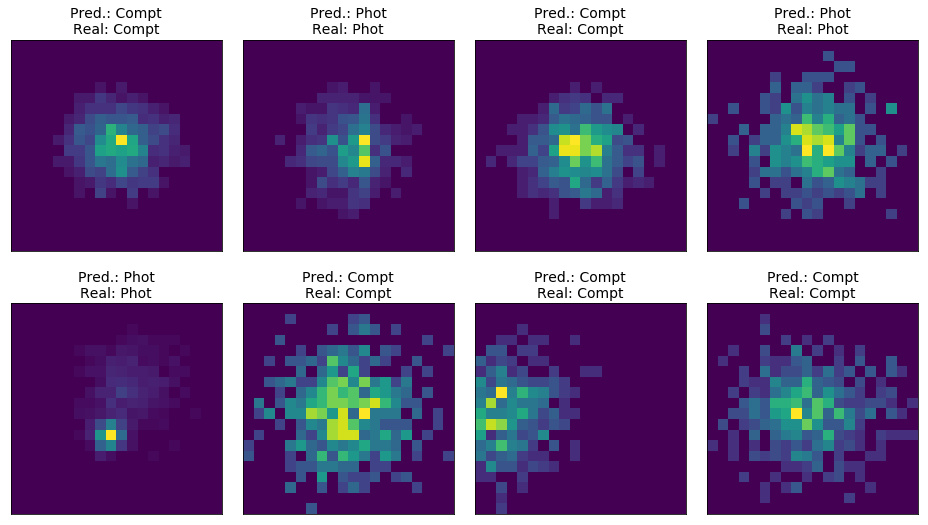

In [65]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [66]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
1505 of total 2000 ---> 75.25 %
------------------------------


In [68]:
tot_true_phot  = np.sum(y_test==1)/100
tot_true_compt = np.sum(y_test==0)/100
print('True phot  labeled as  phot ---> ', np.round(np.sum(result[y_test==1]==1)/tot_true_phot) , '%')
print('True phot  labeled as compt ---> ', np.round(np.sum(result[y_test==1]==0)/tot_true_phot) , '%')
print('True compt labeled as compt ---> ', np.round(np.sum(result[y_test==0]==0)/tot_true_compt), '%')
print('True compt labeled as  phot ---> ', np.round(np.sum(result[y_test==0]==1)/tot_true_compt), '%')

True phot  labeled as  phot --->  61.0 %
True phot  labeled as compt --->  39.0 %
True compt labeled as compt --->  88.0 %
True compt labeled as  phot --->  12.0 %
